In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/FWI_DATASET/FWI_UPDATE.csv', skiprows=1)

df.columns = [col.strip() for col in df.columns]

numeric_columns = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['day']).reset_index(drop=True)

df.insert(0, 'Region', 'Bejaia')
df.loc[122:, 'Region'] = 'Sidi-Bel'

df['Classes'] = df['Classes'].astype(str).str.strip()
df['Classes'] = np.where(df['Classes'] == 'fire', 1, 0)

# Handle missing values using linear interpolation (mean of neighbors)
df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')

df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'] = df['year'].astype(int)
df['Temperature'] = df['Temperature'].astype(int)
df['RH'] = df['RH'].astype(int)
df['Ws'] = df['Ws'].astype(int)
df['Region'] = df['Region'].map({'Bejaia': 0, 'Sidi-Bel': 1}).astype(int)

df.to_csv('Cleaned_FWI_dataset.csv', index=False)
print("Cleaned dataset saved as Cleaned_FWI_dataset.csv")
df.info()

Cleaned dataset saved as Cleaned_FWI_dataset.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       244 non-null    int64  
 1   day          244 non-null    int64  
 2   month        244 non-null    int64  
 3   year         244 non-null    int64  
 4   Temperature  244 non-null    int64  
 5   RH           244 non-null    int64  
 6   Ws           244 non-null    int64  
 7   Rain         244 non-null    float64
 8   FFMC         244 non-null    float64
 9   DMC          244 non-null    float64
 10  DC           244 non-null    float64
 11  ISI          244 non-null    float64
 12  BUI          244 non-null    float64
 13  FWI          244 non-null    float64
 14  Classes      244 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 28.7 KB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Cleaned_FWI_dataset.csv')

df.hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of All Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('histograms.png', dpi=300, bbox_inches='tight')
plt.show()

corr = df.select_dtypes(include='number').corr()

fig, ax = plt.subplots(figsize=(14, 12))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, shrink=0.8)

ticks = np.arange(0, len(corr.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=9)

plt.title('Correlation Heatmap', fontsize=20, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop correlations with FWI (your target):")
print(corr['FWI'].sort_values(ascending=False).round(3))

print("\nTop covariance with FWI:")
print(df.cov(numeric_only=True)['FWI'].sort_values(ascending=False).round(3))

**MILESTONE 1 REACHED**

In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import lstsq

df = pd.read_csv('/content/Cleaned_FWI_dataset.csv')

df = df.drop(['day', 'month', 'year', 'Classes'], axis=1)

# All 9 valid predictive features + Region
features = ['Region', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']
X = df[features].values
y = df['FWI'].values

X = np.column_stack([np.ones(len(y)), X])
coef, residuals, rank, s = lstsq(X, y)

rss = residuals.item() if isinstance(residuals, np.ndarray) else residuals

# Predictions
y_pred = X @ coef

ss_tot = np.sum((y - y.mean())**2)
ss_res = np.sum((y - y_pred)**2)

n, p = X.shape


# MSE
mse = ss_res / n

print("Multiple Linear Regression on FWI (All Correct Features)\n")
print(f"{'Feature':<15} {'Coefficient':>12}")
print("-" * 30)
print(f"{'Intercept':<15} {coef[0]:>12.4f}")
for feat, c in zip(features, coef[1:]):
    print(f"{feat:<15} {c:>12.4f}")


print(f"MSE             : {mse:.4f}")
print(f"Root MSE        : {np.sqrt(mse):.4f}")

Multiple Linear Regression on FWI (All Correct Features)

Feature          Coefficient
------------------------------
Intercept             2.0210
Region               -0.2992
Temperature          -0.0138
RH                   -0.0032
Ws                   -0.0200
Rain                  0.0074
FFMC                 -0.0503
DMC                  -0.0056
DC                   -0.0135
ISI                   1.2085
BUI                   0.3012
MSE             : 1.4449
Root MSE        : 1.2020


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('Cleaned_FWI_dataset.csv')

df = df.drop(['day', 'month', 'year', 'Classes'], axis=1)

features = ['Region', 'Temperature', 'RH', 'Ws', 'Rain',
            'FFMC', 'DMC', 'DC', 'ISI', 'BUI']

X = df[features].values
y = df['FWI'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test,  y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

print("Scikit-learn Linear Regression – FWI Prediction")
print("="*52)
print(f"{'Feature':<15} {'Coefficient':>12}")
print("-"*34)
print(f"{'Intercept':<15} {model.intercept_:>12.4f}")
for f, c in zip(features, model.coef_):
    print(f"{f:<15} {c:>12.4f}")

print("\nPerformance")
print("-"*34)
print(f"Train R²        : {train_r2:.6f}")
print(f"Test  R²        : {test_r2:.6f}")
print(f"Train RMSE      : {train_rmse:.4f}")
print(f"Test  RMSE      : {test_rmse:.4f}")

Scikit-learn Linear Regression – FWI Prediction
Feature          Coefficient
----------------------------------
Intercept             2.2037
Region               -0.2671
Temperature          -0.0200
RH                   -0.0067
Ws                   -0.0250
Rain                  0.0102
FFMC                 -0.0453
DMC                  -0.0199
DC                   -0.0137
ISI                   1.1784
BUI                   0.3160

Performance
----------------------------------
Train R²        : 0.970688
Test  R²        : 0.989688
Train RMSE      : 1.3102
Test  RMSE      : 0.6340


Features used (10 total): ['Region', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']


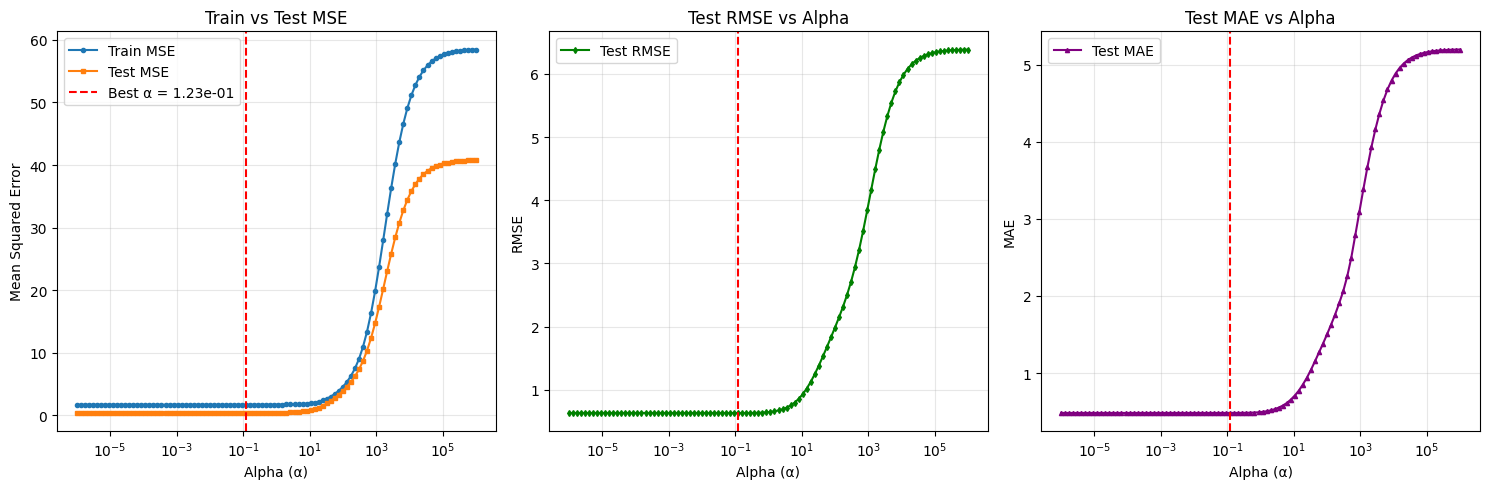


RIDGE REGRESSION – ALL FEATURES KEPT (including BUI)
Optimal Alpha           : 0.123285
Test  R²                : 0.989716
Test  RMSE              : 0.6331
Test  MAE               : 0.4830
Test  (Best Test MSE = 0.400815)

Final Model Coefficients (α = 0.123285):
Feature       Coefficient
----------------------------
Intercept          7.3210
Region            -0.1414
Temperature       -0.0776
RH                -0.0990
Ws                -0.0629
Rain               0.0241
FFMC              -0.6319
DMC                0.0314
DC                -0.5456
ISI                4.9996
BUI                4.3128

Saved: scaler.pkl  &  ridge.pkl  → ready for deployment


In [3]:
# MODULE 3, 4 & 5 – RIDGE REGRESSION (ALL FEATURES KEPT)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('Cleaned_FWI_dataset.csv')
df = df.drop(['day', 'month', 'year', 'Classes'], axis=1)


X = df.drop('FWI', axis=1)
y = df['FWI']

print("Features used (10 total):", list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

alphas = np.logspace(-6, 6, 100)    # wide range: 1e-6 → 1e6

train_mse_list = []
test_mse_list  = []
train_rmse_list = []
test_rmse_list  = []
train_mae_list  = []
test_mae_list   = []

for alpha in alphas:
    model = Ridge(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)
    test_pred  = model.predict(X_test_scaled)

    train_mse_list.append(mean_squared_error(y_train, train_pred))
    test_mse_list.append(mean_squared_error(y_test,  test_pred))

    train_rmse_list.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_rmse_list.append(np.sqrt(mean_squared_error(y_test,  test_pred)))

    train_mae_list.append(mean_absolute_error(y_train, train_pred))
    test_mae_list.append(mean_absolute_error(y_test,  test_pred))

best_idx   = np.argmin(test_mse_list)
best_alpha = alphas[best_idx]

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)

final_r2   = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae  = mean_absolute_error(y_test, y_pred_final)

# Save final model
with open('ridge.pkl', 'wb') as f:
    pickle.dump(final_model, f)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.semilogx(alphas, train_mse_list, label='Train MSE',  marker='o', markersize=3)
plt.semilogx(alphas, test_mse_list,  label='Test MSE',   marker='s', markersize=3)
plt.axvline(best_alpha, color='red', linestyle='--',
            label=f'Best α = {best_alpha:.2e}')
plt.xlabel('Alpha (α)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.semilogx(alphas, test_rmse_list, color='green', label='Test RMSE', marker='d', markersize=3)
plt.axvline(best_alpha, color='red', linestyle='--')
plt.xlabel('Alpha (α)')
plt.ylabel('RMSE')
plt.title('Test RMSE vs Alpha')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.semilogx(alphas, test_mae_list, color='purple', label='Test MAE', marker='^', markersize=3)
plt.axvline(best_alpha, color='red', linestyle='--')
plt.xlabel('Alpha (α)')
plt.ylabel('MAE')
plt.title('Test MAE vs Alpha')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ridge_tuning_all_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("RIDGE REGRESSION – ALL FEATURES KEPT (including BUI)")
print("="*60)
print(f"Optimal Alpha           : {best_alpha:.6f}")
print(f"Test  R²                : {final_r2:.6f}")
print(f"Test  RMSE              : {final_rmse:.4f}")
print(f"Test  MAE               : {final_mae:.4f}")
print(f"Test  (Best Test MSE = {test_mse_list[best_idx]:.6f})")

print(f"\nFinal Model Coefficients (α = {best_alpha:.6f}):")
print(f"{'Feature':<12} {'Coefficient':>12}")
print("-"*28)
print(f"{'Intercept':<12} {final_model.intercept_:12.4f}")
for name, coef in zip(X.columns, final_model.coef_):
    print(f"{name:<12} {coef:12.4f}")

print("\nSaved: scaler.pkl  &  ridge.pkl  → ready for deployment")

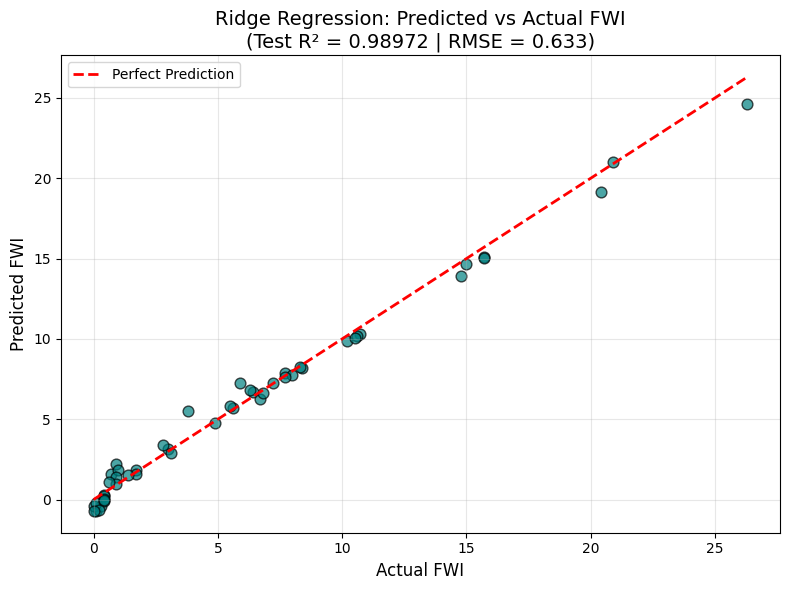

In [5]:
# --------------------- Predicted vs Actual Plot (Test Set) ---------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, alpha=0.7, color='teal', edgecolor='k', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual FWI', fontsize=12)
plt.ylabel('Predicted FWI', fontsize=12)
plt.title(f'Ridge Regression: Predicted vs Actual FWI\n'
          f'(Test R² = {final_r2:.5f} | RMSE = {final_rmse:.3f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Optional: save the plot
plt.savefig('predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()